In [1]:
from google.colab import drive

drive.mount('drive')

Mounted at drive


In [2]:
import torch
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# read mr and ct datasets
MR_train_address = 'drive/MyDrive/MR_CT_data/train_input.npy'
CT_train_address = 'drive/MyDrive/MR_CT_data/train_output.npy'

MR_val_address = 'drive/MyDrive/MR_CT_data/val_input.npy'
CT_val_address = 'drive/MyDrive/MR_CT_data/val_output.npy'

MR_test_address = 'drive/MyDrive/MR_CT_data/test_input.npy'
CT_test_address = 'drive/MyDrive/MR_CT_data/test_output.npy'

mr_train = np.load(MR_train_address)
ct_train = np.load(CT_train_address)

mr_val = np.load(MR_val_address)
ct_val = np.load(CT_val_address)

mr_test = np.load(MR_test_address)
ct_test = np.load(CT_test_address)

In [5]:
ct_train.shape, ct_val.shape, ct_test.shape

((570, 256, 256), (90, 256, 256), (150, 256, 256))

In [6]:
# resizes a 1d numpy array to an arbitrary size
def resize(img, size):

  img = img.astype('float32')
  img = torch.tensor(img)
  img = img.unsqueeze(0)

  transform = T.Resize(size, antialias=False)
  resized_img = transform(img)

  resized_img = np.array(resized_img)
  # resized_img = np.reshape(resized_img, (size, size, 1))

  return resized_img

In [7]:
n_train_samples = ct_train.shape[0]
n_val_samples = ct_val.shape[0]
n_test_samples = ct_test.shape[0]

n_add_from_test_to_train = 90

n_train_new = n_train_samples + n_val_samples + n_add_from_test_to_train
n_test_new = n_test_samples - n_add_from_test_to_train

mr_train_resized = [None] * n_train_new
ct_train_resized = [None] * n_train_new

mr_test_resized = [None] * n_test_new
ct_test_resized = [None] * n_test_new

for i in range(n_train_samples):

  mr_train_resized[i] = resize(mr_train[i], 64)
  ct_train_resized[i] = resize(ct_train[i], 64)

for i in range(n_val_samples):

  j = i + n_train_samples

  mr_train_resized[j] = resize(mr_val[i], 64)
  ct_train_resized[j] = resize(ct_val[i], 64)


for i in range(n_add_from_test_to_train):

  j = i + n_train_samples + n_val_samples

  mr_train_resized[j] = resize(mr_test[i], 64)
  ct_train_resized[j] = resize(ct_test[i], 64)


for i in range(n_test_new):

  j = i + n_add_from_test_to_train

  mr_test_resized[i] = resize(mr_test[j], 64)
  ct_test_resized[i] = resize(ct_test[j], 64)

# convert lists of mr and ct to tensors
mr_train_resized = np.array(mr_train_resized)
mr_train_resized = torch.tensor(mr_train_resized)

mr_test_resized = np.array(mr_test_resized)
mr_test_resized = torch.tensor(mr_test_resized)

ct_train_resized = np.array(ct_train_resized)
ct_train_resized = torch.tensor(ct_train_resized)

ct_test_resized = np.array(ct_test_resized)
ct_test_resized = torch.tensor(ct_test_resized)

print('train images shape:', mr_train_resized.shape)
print('test images shape:', mr_test_resized.shape)

train images shape: torch.Size([750, 1, 64, 64])
test images shape: torch.Size([60, 1, 64, 64])


In [8]:
train_dataset = TensorDataset(mr_train_resized, ct_train_resized)
test_dataset = TensorDataset(mr_test_resized, ct_test_resized)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# Define the DiffusionModel architecture
class DiffusionModel(nn.Module):
  def __init__(self, in_channels, out_channels, diffusion_steps):
    super(DiffusionModel, self).__init__()

    self.diffusion_steps = diffusion_steps

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
        nn.Tanh()
    )

    # Noise Generator
    self.noise_generator = nn.Sequential(
        nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
        nn.Tanh()
    )

  def forward(self, mri_image):

    # Pass the MRI image through the encoder
    encoded = self.encoder(mri_image)

    # Initialize the CT image as the encoded MRI image
    ct_image = encoded

    # # Perform diffusion steps
    # for _ in range(self.diffusion_steps):
      # # Generate noise
      # noise = self.noise_generator(ct_image)

      # # Add noise to the CT image
      # ct_image = ct_image + noise

      # # Pass the CT image through the decoder
      # ct_image = self.decoder(ct_image)
    ct_image = self.decoder(ct_image)

    return ct_image

# Define the training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
  model.train()

  step_size = 100

  for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (inputs, targets) in enumerate(train_loader):

      inputs = inputs.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()

      # Forward pass
      outputs = model(inputs)

      # Compute the loss
      loss = criterion(outputs, targets)

      # Backward pass and optimization
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    if (epoch+1) == 1 or (epoch+1) % step_size == 0:
      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


# Example usage

in_channels = 1  # Number of input channels (grayscale MRI image)
out_channels = 1  # Number of output channels (grayscale CT image)

diffusion_steps = 5  # Number of diffusion steps
num_epochs = 10000  # Number of training epochs
learning_rate = 0.001  # Learning rate

# Set up your training dataset and dataloader
# train_dataset = train_dataset
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True)

# Create an instance of the DiffusionModel
model = DiffusionModel(in_channels, out_channels, diffusion_steps)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10000], Loss: 0.0387
Epoch [100/10000], Loss: 0.0091
Epoch [200/10000], Loss: 0.0076
Epoch [300/10000], Loss: 0.0071
Epoch [400/10000], Loss: 0.0067
Epoch [500/10000], Loss: 0.0065
Epoch [600/10000], Loss: 0.0064
Epoch [700/10000], Loss: 0.0062
Epoch [800/10000], Loss: 0.0061
Epoch [900/10000], Loss: 0.0060
Epoch [1000/10000], Loss: 0.0060
Epoch [1100/10000], Loss: 0.0060
Epoch [1200/10000], Loss: 0.0059
Epoch [1300/10000], Loss: 0.0059
Epoch [1400/10000], Loss: 0.0059
Epoch [1500/10000], Loss: 0.0058
Epoch [1600/10000], Loss: 0.0058
Epoch [1700/10000], Loss: 0.0058
Epoch [1800/10000], Loss: 0.0057
Epoch [1900/10000], Loss: 0.0057
Epoch [2000/10000], Loss: 0.0057
Epoch [2100/10000], Loss: 0.0057
Epoch [2200/10000], Loss: 0.0057
Epoch [2300/10000], Loss: 0.0057
Epoch [2400/10000], Loss: 0.0056
Epoch [2500/10000], Loss: 0.0056
Epoch [2600/10000], Loss: 0.0056
Epoch [2700/10000], Loss: 0.0056
Epoch [2800/10000], Loss: 0.0057
Epoch [2900/10000], Loss: 0.0056
Epoch [3000/10000], Lo

In [10]:
# After training the model
saved_model_path = f"drive/MyDrive/MR_CT_model/model_weights_epochs_{num_epochs}.pth"
torch.save(model.state_dict(), saved_model_path)

In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

# # Define the DiffusionModel architecture
# class DiffusionModel(nn.Module):
#     def __init__(self, in_channels, out_channels, diffusion_steps):
#         super(DiffusionModel, self).__init__()

#         self.diffusion_steps = diffusion_steps

#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
#             nn.Tanh()
#         )

#         # Noise Generator
#         self.noise_generator = nn.Sequential(
#             nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
#             nn.Tanh()
#         )

#     def forward(self, mri_image):
#         # Pass the MRI image through the encoder
#         encoded = self.encoder(mri_image)

#         # Initialize the CT image as the encoded MRI image
#         ct_image = encoded

#         # Perform diffusion steps
#         for _ in range(self.diffusion_steps):
#             # Generate noise
#             noise = self.noise_generator(ct_image)

#             # Add noise to the CT image
#             ct_image = ct_image + noise

#             # Pass the CT image through the decoder
#             ct_image = self.decoder(ct_image)

#         return ct_image

outputs_save_dir = 'drive/MyDrive/MR_CT_outputs'
outputs_save_folder = os.path.join(outputs_save_dir, f'epochs_{num_epochs}_')
os.mkdir(outputs_save_folder)

# Define the testing loop
def test_model(model, test_loader, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):

      inputs = inputs.to(device)
      targets = targets.to(device)
      # Forward pass
      outputs = model(inputs)

      outputs_save_filename = f'outputs_batch{i}'
      outputs_save_path = os.path.join(outputs_save_folder, outputs_save_filename)

      np.save(outputs_save_path, np.array(outputs.cpu()))

      # Compute the loss
      loss = criterion(outputs, targets)

      total_loss += loss.item()

  avg_loss = total_loss / len(test_loader)
  print(f"Average Loss: {avg_loss:.4f}")

# Example usage
in_channels = 1  # Number of input channels (grayscale MRI image)
out_channels = 1  # Number of output channels (grayscale CT image)
diffusion_steps = 5  # Number of diffusion steps

# Set up your testing dataset and dataloader
# test_dataset = YourTestDataset(...)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False)



# Load the trained model weights
# gauth = GoogleAuth()
# drive = GoogleDrive(gauth)

# file_id = 'your_file_id_here'

# file = drive.CreateFile({'id': file_id})
# file.GetContentFile('model_weights.pth')

model = DiffusionModel(in_channels, out_channels, diffusion_steps)
model.to(device)
model.load_state_dict(torch.load(saved_model_path))


# model = model.load_state_dict(torch.load(saved_model_path))

# Define the loss function
criterion = nn.MSELoss()

# Test the model
test_model(model, test_loader, criterion)

Average Loss: 0.0384


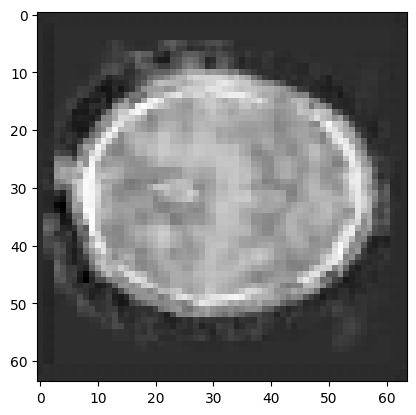

In [15]:
batch_number = 0
outputs_save_filename = f'outputs_batch{batch_number}.npy'
saved_outputs = os.path.join(outputs_save_folder, outputs_save_filename)

outputs = np.load(saved_outputs)

n_samples = 1

for i in range(n_samples):
  output = outputs[i]
  output = np.reshape(output, (64, 64, 1))
  plt.imshow(output, cmap='gray')
  plt.show()

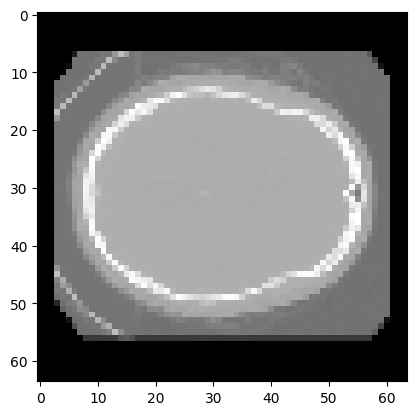

In [16]:
test_sample = ct_test_resized[0]
test_sample = np.reshape(test_sample, (64, 64, 1))
plt.imshow(test_sample, cmap='gray')

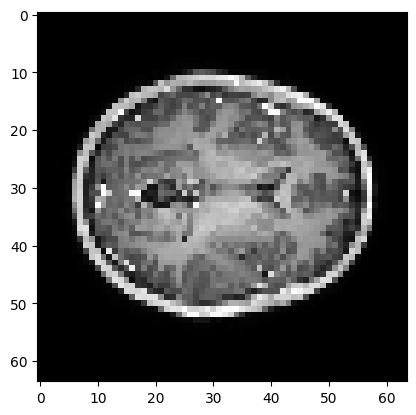

In [14]:
mr_sample = mr_test_resized[0]
mr_sample = np.reshape(mr_sample, (64, 64, 1))
plt.imshow(mr_sample, cmap='gray')